In [8]:
import os
from typing import Annotated

from IPython.display import Image, display
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_core.messages import AIMessage, AnyMessage, HumanMessage
from langchain_ollama import ChatOllama
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel, field_serializer

In [9]:
def add(a: float, b: float) -> float:
    """
    Add two numbers.

    Args:
        a (float): The first number.
        b (float): The second number.

    Returns:
        float: The sum of a and b.
    """
    return a + b

def multiply(a: float, b: float) -> float:
    """
    Multiply two numbers.

    Args:
        a (float): The first number.
        b (float): The second number.

    Returns:
        float: The product of a and b.
    """
    return a * b

In [10]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

tavily = TavilySearch()

In [11]:
tools = [arxiv, wiki, tavily, add, multiply]
llm = ChatOllama(model="qwen2.5")
llm = llm.bind_tools(tools=tools)

In [ ]:
class State(BaseModel):
    messages: Annotated[list[AnyMessage], add_messages]

    @field_serializer
    def messages_serializers(self, messages: list[AnyMessage]) -> list[dict]:
        return [message.model_dump() for message in messages]


class LlmWithTools:
    def __init__(self, llm: ChatOllama) -> None:
        self.llm = llm

    def __call__(self, state: State) -> dict:
        return dict(messages=self.llm.invoke(state.messages))

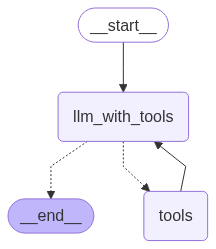

In [13]:
builder = StateGraph(State)
builder.add_node("llm_with_tools", LlmWithTools(llm))
builder.add_node("tools", ToolNode(tools=tools))

builder.add_edge(START, "llm_with_tools")
builder.add_conditional_edges("llm_with_tools", tools_condition)
builder.add_edge("tools", "llm_with_tools")
builder.add_edge("llm_with_tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
result = graph.invoke(
    dict(messages=[HumanMessage(content="Provide the 10 most recent AI news of today.", name="Hyan")])
)
_ = [message.pretty_print() for message in result.get("messages")]

================================ Human Message =================================
Name: Hyan

Provide the 10 most recent AI news of today.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (9c0d3713-ef32-4c9b-bb14-41710317af55)
 Call ID: 9c0d3713-ef32-4c9b-bb14-41710317af55
  Args:
    query: AI news
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.youtube.com/watch?v=kOQ5QWfsGJE", "title": "The BEAST is UNLEASHED! Latest AI News to blow your mind!", "content": "HUGE Thanks to Invideo AI for sponsoring today's video, check out their one of a kind v4 model here; it's the only AI out there that can one shot entire", "score": 0.66621506, "raw_content": null}, {"url": "https://komonews.com/news/local/microsoft-president-brad-smith-lay

In [15]:
result = graph.invoke(
    dict(messages=[HumanMessage(content="What is machine learning?", name="Hyan")])
)
_ = [message.pretty_print() for message in result.get("messages")]

================================ Human Message =================================
Name: Hyan

What is machine learning?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (81becf46-e2b0-4e7f-905a-8ec70675760b)
 Call ID: 81becf46-e2b0-4e7f-905a-8ec70675760b
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
================================== Ai Message =========

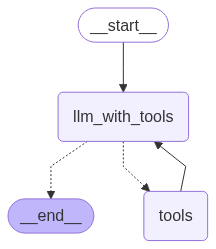

In [16]:
builder = StateGraph(State)
builder.add_node("llm_with_tools", LlmWithTools(llm))
builder.add_node("tools", ToolNode(tools=tools))

builder.add_edge(START, "llm_with_tools")
builder.add_conditional_edges("llm_with_tools", tools_condition)
builder.add_edge("tools", "llm_with_tools")
builder.add_edge("llm_with_tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

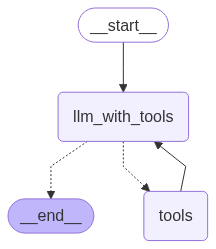

In [17]:
memory = MemorySaver()
graph_with_memory = builder.compile(checkpointer=memory)

display(Image(graph_with_memory.get_graph().draw_mermaid_png()))

In [18]:
config = {"configurable": {"thread_id": "1"}}
result = graph_with_memory.invoke(dict(messages=[HumanMessage(content="What is 15 plus 15")]), config=config)
_ = [message.pretty_print() for message in result.get("messages")]

================================ Human Message =================================

What is 15 plus 15
================================== Ai Message ==================================
Tool Calls:
  add (46795c2d-b48e-41b5-8467-013f3085a965)
 Call ID: 46795c2d-b48e-41b5-8467-013f3085a965
  Args:
    a: 15
    b: 15
================================= Tool Message =================================
Name: add

30.0
================================== Ai Message ==================================

The result of 15 plus 15 is 30.


In [19]:
config = {"configurable": {"thread_id": "1"}}
result = graph_with_memory.invoke(dict(messages=[HumanMessage(content="Now, multiply the result by 2")]), config=config)
_ = [message.pretty_print() for message in result.get("messages")]

================================ Human Message =================================

What is 15 plus 15
================================== Ai Message ==================================
Tool Calls:
  add (46795c2d-b48e-41b5-8467-013f3085a965)
 Call ID: 46795c2d-b48e-41b5-8467-013f3085a965
  Args:
    a: 15
    b: 15
================================= Tool Message =================================
Name: add

30.0
================================== Ai Message ==================================

The result of 15 plus 15 is 30.
================================ Human Message =================================

Now, multiply the result by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (336cd3fc-7833-4077-a530-b6073f15b79e)
 Call ID: 336cd3fc-7833-4077-a530-b6073f15b79e
  Args:
    a: 30
    b: 2
================================= Tool Message =================================
Name: multiply

60.0
================================== Ai Messag